In [192]:
### QUANTUM_TUTORIAL가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QUANTUM_TUTORIAL"

In [193]:
from dimod import ConstrainedQuadraticModel, Integer, QuadraticModel
from dwave.system import LeapHybridCQMSampler
import os
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf
from graph.graph import *
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import algorithm_globals
algorithm_globals.massive=True

import time

import numpy as np
import pandas as pd
%matplotlib inline


## DWAVE Quantum Algorithm

#### Quadratic Unconstrained Binary Optimization (QUBO)

$$
\underset{x \in \{0,1\}^{\otimes n}}{\min}  x^t Q x + \beta^t x = \sum_{i} \sum_{j} q_{ij}x_i x_j + \sum_{i} x_i 
$$

In [194]:
my_api_token = "yXwP-f2aec33bfee8942f29378398525e5bb738779590"
sampler = LeapHybridCQMSampler(token = my_api_token)

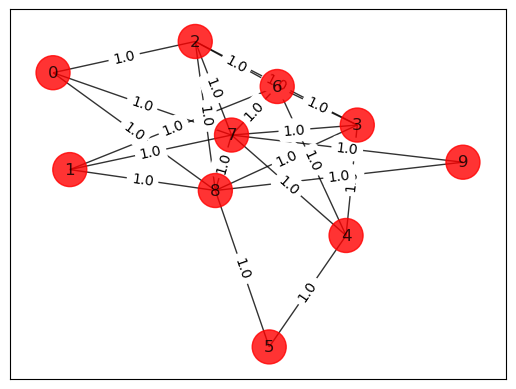

In [195]:
n=10
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

draw_graph(G, colors, pos)

#### Max-Cut 문제
- 각 노드별로 0/1 번 인덱스를 할당한 후 양옆으로 0번 군집, 1번 군집대로 정렬했을때 이 두 군집을 잇는 선을 최대화 시키는 문제. 
- 노드 별로 거리가 멀면 직선을 긋고, 거리가 가까우면 직선을 긋지 않을때 Max Cut 문제는 결과적으로 거리가 가까운 노드 끼리는 같은 군집에, 거리가 먼 노드끼리는 다른 군집에 연결시키는 클러스터링 문제가 된다. 

- 개별 노드는 0번에 할당될 수도 있고 1번에 할당 될수도 있다. 따라서 총 $p$개의 노드가 있을때 $2^p$개의 경우의 수가 존재한다. 노드가 10개일때는 1024개, 20개 일때는 100만개, 200개 일때는 대략 $10^{60}$(나유타)개의 경우의 수가 있어서 정확한 최소값을 찾는 것이 사실상 불가능하다. 

- 이 문제를 잘 변형 시키면 p개의 자산의 포트폴리오 최적화 문제, $\sqrt{p}$개 도시의 최적 루트 찾기 문제 등으로 치환할 수 있다. 

In [196]:
Q,beta = get_qb_from_adj(w)
p = len(Q)
mod = QuadraticProgram()
linear = {"x" + str(i) : beta[i] for i in range(p)}
quadratic = {("x"+str(i),"x"+str(j)):Q[i,j] for i in range(p) for j in range(p)}
for i in range(p):
    mod.binary_var(name = "x"+str(i))
mod.minimize(linear = linear , quadratic = quadratic)
print(mod.prettyprint())

Problem name: 

Minimize
  4*x0*x2 + 4*x0*x7 + 4*x0*x8 + 4*x1*x6 + 4*x1*x7 + 4*x1*x8 + 4*x2*x3 + 4*x2*x6
  + 4*x2*x7 + 4*x2*x8 + 4*x3*x4 + 4*x3*x6 + 4*x3*x7 + 4*x3*x8 + 4*x4*x5
  + 4*x4*x6 + 4*x4*x7 + 4*x5*x8 + 4*x6*x7 + 4*x7*x8 + 4*x7*x9 + 4*x8*x9 - 3*x0
  - 3*x1 - 5*x2 - 5*x3 - 4*x4 - 2*x5 - 5*x6 - 8*x7 - 7*x8 - 2*x9

Subject to
  No constraints

  Binary variables (10)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9



- 이 Max Cut 문제는 QUBO로 바꾸어서 쓸 수 있다. 

In [197]:
start = time.time()
solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)
label_exact = result.x
time_exact = time.time()-start
random_label = np.random.randint(0,2,len(result.x))*1.0


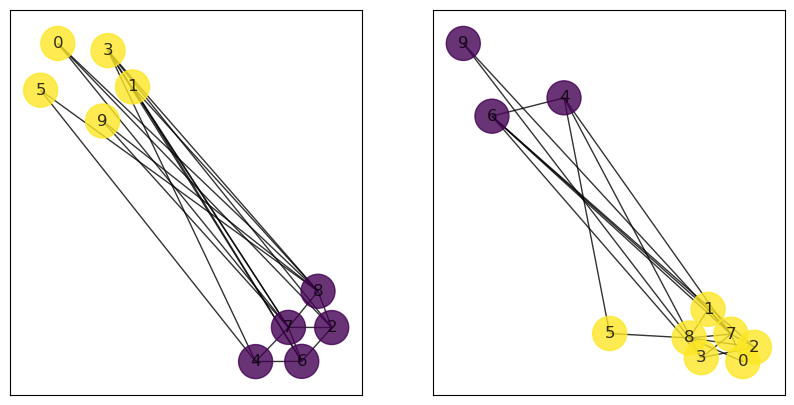

In [202]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
label = label_exact 
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
draw_graph(G,label, pos,axes[0],edgelabel=False)
random_label = np.random.randint(0,2,len(result.x))*1.0
label = random_label
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
draw_graph(G,label, pos,axes[1],edgelabel=False)

In [203]:
print("Minimum Value : ",maxcut_score(label_exact ,w),", Random Value : ",maxcut_score(random_label,w))

Minimum Value :  15 , Random Value :  9


- 총 10개의 그래프에 대해서 좌측은 총 1024개의 경우의 수 중 최대값을 주는 조합을 찾은 것이고 우측은 비교용으로 랜덤한 값을 주었다. 두 클러스터를 잇는 직선의 수는 최대 16개이다. 

이 문제를 연습삼아서 양자 컴퓨터를 이용한 방법 (DWAVE 의 머신을 이용한 Quantum Annealing 알고리즘)으로도 풀고 일반적으로 사용하던 방법 (Simulated Annealing 방법)으로도 풀어보자.

In [204]:
my_api_token = "yXwP-f2aec33bfee8942f29378398525e5bb738779590"
sampler = LeapHybridCQMSampler(token = my_api_token)

In [205]:
opt_dwave = opt.DWAVE_optimizer(sampler)
opt_sa = opt.SimulatedAnnealing()

start = time.time()
opt_sa.optimize(Q,beta)
time_sa = time.time()-start 

start = time.time()
opt_dwave.optimize(Q,beta)
time_dwave = time.time()-start

/Users/minhyeong-gyu/Documents/GitHub/QUANTUM_TUTORIAL/Module/optimizer/optimizer.py:82: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(theta_temp, Q = Q, beta = beta, lmbd = lamda)-obj(theta_star, Q = Q, beta = beta, lmbd = lamda))/tau)):


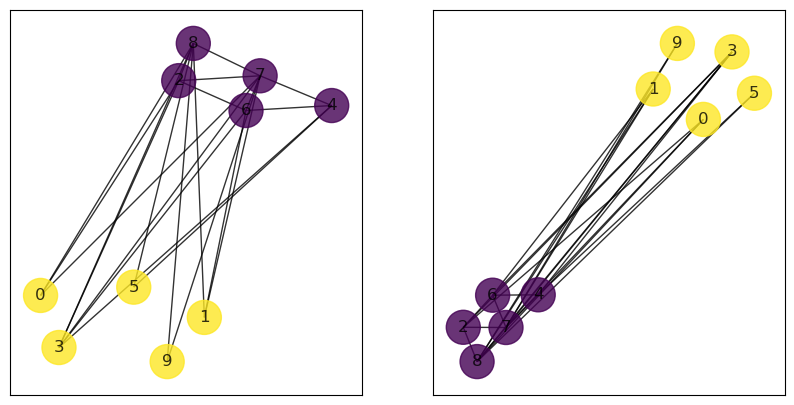

In [206]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
label = opt_sa.result
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
draw_graph(G,label, pos,axes[0],edgelabel=False)

random_label = np.random.randint(0,2,len(result.x))*1.0
label = opt_dwave.result
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
draw_graph(G,label, pos,axes[1],edgelabel=False)

In [207]:
result_table = pd.DataFrame([[maxcut_score(label_exact,w),maxcut_score(opt_sa.result,w),maxcut_score(opt_dwave.result,w)],
[time_exact,time_sa,time_dwave]])
result_table.index = ["Max-Cut Score","Operating Time"]
result_table.columns = ["Exact","Classical Methods (SA)","Quantum Methods (DWAVE)"]
result_table

,Exact,Classical Methods (SA),Quantum Methods (DWAVE)
Max-Cut Score,15.000000,15.000000,15.000000
Operating Time,0.039988,1.504167,12.863651


- 총 10개 노드의 문제에 대해서 1024개의 모든 경우의 수를 다보는 건 오직 0.03초 밖에 걸리지 않는다.
- SA로 이 문제를 풀때는 1초를 조금 넘어섰다.
- DWAVE를 이용하여 문제를 풀때는 13초 정도 걸렸고 스코어도 약간 낮다. 

결론적으로 문제의 스케일이 매우 낮을때는 그냥 모든 경우의 수를 다 확인해서 그 중 가장 낮은것을 체크하면 된다.  
 이제 문제의 스케일을 조금만 키워보자. 

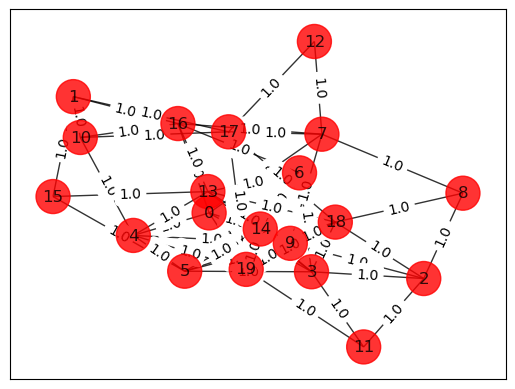

In [179]:
n=20
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

draw_graph(G, colors, pos)

In [184]:
Q,beta = get_qb_from_adj(w)
p = len(Q)
mod = QuadraticProgram()
linear = {"x" + str(i) : beta[i] for i in range(p)}
quadratic = {("x"+str(i),"x"+str(j)):Q[i,j] for i in range(p) for j in range(p)}
for i in range(p):
    mod.binary_var(name = "x"+str(i))
mod.minimize(linear = linear , quadratic = quadratic)

In [185]:
start = time.time()
result = optimizer.solve(mod)
label_exact = result.x
time_exact = time.time()-start

start = time.time()
opt_sa.optimize(Q,beta)
time_sa = time.time()-start 

start = time.time()
opt_dwave.optimize(Q,beta)
time_dwave = time.time()-start

/Users/minhyeong-gyu/Documents/GitHub/QUANTUM_TUTORIAL/Module/optimizer/optimizer.py:82: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(theta_temp, Q = Q, beta = beta, lmbd = lamda)-obj(theta_star, Q = Q, beta = beta, lmbd = lamda))/tau)):


In [186]:
result_table = pd.DataFrame([[maxcut_score(label_exact,w),maxcut_score(opt_sa.result,w),maxcut_score(opt_dwave.result,w)],
[time_exact,time_sa,time_dwave]])
result_table.index = ["Max-Cut Score","Operating Time"]
result_table.columns = ["Exact","Classical Methods (SA)","Quantum Methods (DWAVE)"]
result_table

,Exact,Classical Methods (SA),Quantum Methods (DWAVE)
Max-Cut Score,40.000000,40.000000,40.000000
Operating Time,31.787243,1.469135,13.780776


- 세 알고리즘이 모두 동일한 최대값을 도출해내는데 성공했다. 
- Exact로 풀때는 0.03에서 30초로 시간이 1000배 가량 증가했다. 
- SA의 경우에는 시간도 스코어도 모두 적절하다. 

그러나 20개의 케이스일때도 여전히 매우 작은 수치이다. 이번에는 200개로 하여 좀 더 현실적인 문제에 적용해보자. 

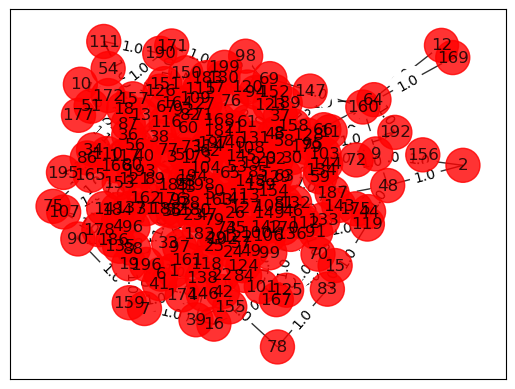

In [213]:
n=200
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

draw_graph(G, colors, pos)

In [214]:
Q,beta = get_qb_from_adj(w)
p = len(Q)
mod = QuadraticProgram()
linear = {"x" + str(i) : beta[i] for i in range(p)}
quadratic = {("x"+str(i),"x"+str(j)):Q[i,j] for i in range(p) for j in range(p)}
for i in range(p):
    mod.binary_var(name = "x"+str(i))
mod.minimize(linear = linear , quadratic = quadratic)

In [215]:
start = time.time()
opt_sa.optimize(Q,beta)
time_sa = time.time()-start 

start = time.time()
opt_dwave.optimize(Q,beta)
time_dwave = time.time()-start

result_table = pd.DataFrame([[maxcut_score(opt_sa.result,w),maxcut_score(opt_dwave.result,w)],
[time_sa,time_dwave]])
result_table.index = ["Max-Cut Score","Operating Time"]
result_table.columns = ["Classical Methods (SA)","Quantum Methods (DWAVE)"]
result_table

/Users/minhyeong-gyu/Documents/GitHub/QUANTUM_TUTORIAL/Module/optimizer/optimizer.py:82: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(theta_temp, Q = Q, beta = beta, lmbd = lamda)-obj(theta_star, Q = Q, beta = beta, lmbd = lamda))/tau)):


,Classical Methods (SA),Quantum Methods (DWAVE)
Max-Cut Score,409.000000,434.00000
Operating Time,17.551641,15.22205


- SA와 DWAVE의 속도가 비슷해졌고 또 DWAVE가 더 좋은 값을 반환하는 것을 확인할 수 있다. 